# CLIP-DINOiser visualization demo 🖼️

In [ ]:
from hydra.core.global_hydra import GlobalHydra
import os
from models.builder import build_model
from helpers.visualization import mask2rgb
from segmentation.datasets import PascalVOCDataset
from hydra import compose, initialize
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch.nn.functional as F
import numpy as np
from operator import itemgetter 
import torch
import warnings
warnings.filterwarnings('ignore')
GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
# 
# def visualize_per_image(file_path, text_prompts, palette, model):
#     assert os.path.isfile(file_path), f"No such file: {file_path}"
# 
#     img = Image.open(file_path).convert('RGB')
#     img_tens = T.PILToTensor()(img).unsqueeze(0).to(device) / 255.
# 
#     h, w = img_tens.shape[-2:]
#     output = model(img_tens).cpu()
#     output = F.interpolate(output, scale_factor=model.vit_patch_size, mode="bilinear", align_corners=False)[..., :h, :w]
#     output = output[0].argmax(dim=0)
#     mask = mask2rgb(output, palette)
# 
#     fig = plt.figure(figsize=(3, 1))
#     classes = np.unique(output).tolist()
#     plt.imshow(np.array(itemgetter(*classes)(PALETTE)).reshape(1, -1, 3))
#     plt.xticks(np.arange(len(classes)), list(itemgetter(*classes)(text_prompts)), rotation=45)
#     plt.yticks([])
# 
#     return mask, fig, img
# check_path = './checkpoints/last.pt'
# check = torch.load(check_path, map_location='cpu')
# dinoclip_cfg = "clip_dinoiser.yaml"
# cfg = compose(config_name=dinoclip_cfg)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'PascalVOCDataset.CLASSES: {PascalVOCDataset.CLASSES}')
# model = build_model(cfg.model, class_names=PascalVOCDataset.CLASSES).to(device)
# model.clip_backbone.decode_head.use_templates=False # switching off the imagenet templates for fast inference
# model.load_state_dict(check['model_state_dict'], strict=False)
# model = model.eval()
# 
# # TEST WITH BACKGROUND DETECTOR
# file = 'assets/vintage_bike.jpeg'
# PALETTE = [(0, 0, 0), (156, 143, 189), (79, 158, 101)]
# 
# # specify your prompts
# TEXT_PROMPTS = ['background', 'vintage bike', 'leather bag']
# model.clip_backbone.decode_head.update_vocab(TEXT_PROMPTS)
# model.to(device)
# 
# # set apply FOUND (background detector) to True
# model.apply_found = True
# 
# # run segmentation
# mask, ticks, img = visualize_per_image(file, TEXT_PROMPTS, PALETTE, model)
# 
# fig, ax = plt.subplots(nrows=1, ncols=2)
# alpha=0.5
# blend = (alpha)*np.array(img)/255. + (1-alpha) * mask/255.
# ax[0].imshow(blend)
# ax[1].imshow(mask)
# ax[0].axis('off')
# ax[1].axis('off')
# 
# # TEST WITHOUT BACKGROUND DETECTOR
# 
# file = 'assets/rusted_van.png'
# 
# PALETTE = [[25, 29, 136], [128, 112, 112], [85, 124, 85], [250, 112, 112], [250, 250, 0], [250, 0, 0]]
# 
# # specify TEXT PROMPTS
# TEXT_PROMPTS = ["rusted van", "green trees", "foggy clouds", "mountains"] 
# model.clip_backbone.decode_head.update_vocab(TEXT_PROMPTS)
# model.to(device)
# 
# # specify whether applying FOUND or not
# model.apply_found = False
# mask, ticks, img = visualize_per_image(file, TEXT_PROMPTS, PALETTE, model)
# 
# fig, ax = plt.subplots(nrows=1, ncols=2)
# alpha=0.5
# blend = (alpha)*np.array(img)/255. + (1-alpha)*mask/255.
# ax[0].imshow(blend)
# ax[1].imshow(mask)
# ax[0].axis('off')
# ax[1].axis('off')


In [46]:
def visualize_per_image(file_path, support_files, palette, model, class_names):
    # Assert that the main image exists
    assert os.path.isfile(file_path), f"No such file: {file_path}"
    
    dataset_classes = PascalVOCDataset.CLASSES
    
    # print(f"Dataset classes: {dataset_classes}")

    # Open and preprocess the main image
    img = Image.open(file_path).convert('RGB')
    img_tens = T.PILToTensor()(img).unsqueeze(0).to(device) / 255.

    # Load and preprocess support images
    support_images = []
    for support_file in support_files:
        assert os.path.isfile(support_file), f"No such file: {support_file}"
        support_img = Image.open(support_file).convert('RGB')

        # Resize the support images to match the size of the main image
        support_img_resized = support_img.resize(img.size, Image.BILINEAR)

        # Convert to tensor and normalize
        support_img_tens = T.PILToTensor()(support_img_resized).unsqueeze(0).to(device) / 255.
        support_images.append(support_img_tens)
    
    # Stack the support images into a batch
    support_images = torch.cat(support_images, dim=0).to(device)  
    # for spt in support_images:
    #     print(spt.shape)
    
    # Get the original height and width of the image
    h, w = img_tens.shape[-2:]
    merged = torch.cat((img_tens, support_images), dim=0)
    # print(f'merged: {merged.shape}')
    
    # Run the model for segmentation using both the main image and the support images
    output = model(merged).cpu()  # Ensure your model can accept both inputs
    output = F.interpolate(output, scale_factor=model.vit_patch_size, mode="bilinear", align_corners=False)[..., :h, :w]
    
    # Visualizza le probabilità per ogni classe
    # output[0] contiene le probabilità per ciascun pixel e ciascuna classe
    # output[0].shape sarà [C, H, W], dove C è il numero di classi
    
    # Itera su tutte le classi per stampare le probabilità
    # C, H, W = output[0].shape
    # for class_idx in range(C):
    #     class_probs = output[0][class_idx]
    #     print(f"Classe {class_idx}:")
    #     print(f"Probabilità media per classe {class_idx}: {class_probs.mean().item()}")
    #     print("-" * 50)
    
    output = output[0].argmax(dim=0)  # Get the most likely class for each pixel
    
    # Convert the output to an RGB mask using the provided palette
    mask = mask2rgb(output, palette)

    # Extract unique class indices from the output mask and map to the palette
    detected_classes = np.unique(output).tolist()
    # print(f"Detected classes (indices): {detected_classes}")

    # Filter out the classes that were not detected and print their names
    detected_class_names = [class_names[idx] for idx in detected_classes if idx < len(class_names)]
    # print(f"Detected class names: {detected_class_names}")

    # Create the visualization: segmented mask and original image
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    # Blending the original image with the mask for visualization
    alpha = 0.5
    blend = (alpha) * np.array(img) / 255. + (1 - alpha) * mask / 255.
    ax[0].imshow(blend)
    ax[0].axis('off')
    
    ax[1].imshow(mask)
    ax[1].axis('off')
    
    # Visualization of class colors along with support image file names as labels
    class_colors = np.array([palette[class_idx] for class_idx in detected_classes if class_idx < len(palette)])
    plt.figure(figsize=(6, 1))
    plt.imshow(class_colors.reshape(1, -1, 3))
    plt.xticks(np.arange(len(detected_class_names)), detected_class_names, rotation=45)
    plt.yticks([])

    return mask, fig, img


In [ ]:
check_path = './checkpoints/last.pt'
check = torch.load(check_path, map_location='cpu')
dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model(cfg.model, class_names=PascalVOCDataset.CLASSES).to(device)
model.clip_backbone.decode_head.use_templates = False  # switching off the imagenet templates for fast inference
model.load_state_dict(check['model_state_dict'], strict=False)
model = model.eval()

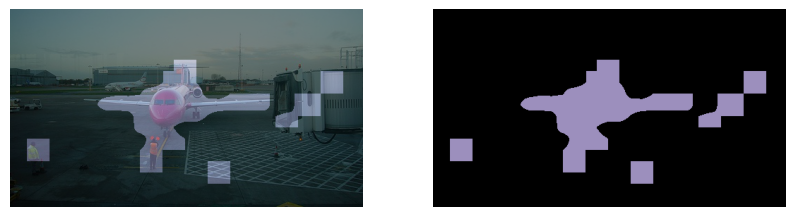

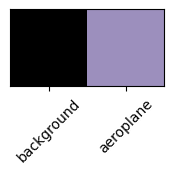

In [48]:
# TEST WITH TWO SUPPORT IMAGES
file = 'assets/airplane.jpg'
support_files = ['assets/air2.jpg']  # Two support images

PALETTE = [(0, 0, 0), (156, 143, 189), (79, 158, 101)]

# Run segmentation with two support images, no text prompts required
model.apply_found = True  # assuming this flag is still relevant for your setup

# Lista dei nomi delle classi (questo esempio è per 3 classi)
class_names = ['background', 'aeroplane', 'bicycle']
# Run segmentation
mask, ticks, img = visualize_per_image(file, support_files, PALETTE, model, class_names)